<a href="https://colab.research.google.com/github/zsun360/zsun360.github.io/blob/main/Q3_Fourier_Recon_Min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q3 — Fourier Reconstruction: Magnitude vs Phase (Concise Notebook)

**Goal:** Reconstruct an image from its Fourier transform in three ways:  
1) **Magnitude-only** (set phase to 0)  
2) **Phase-only** (set magnitude to 1)  
3) **Both magnitude and phase** (original reconstruction)  

This follows the classic observation in Oppenheim et al. (1983, *JOSA*) that **phase carries most structural information**.

In [1]:
# Minimal imports
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, img_as_float32
import os

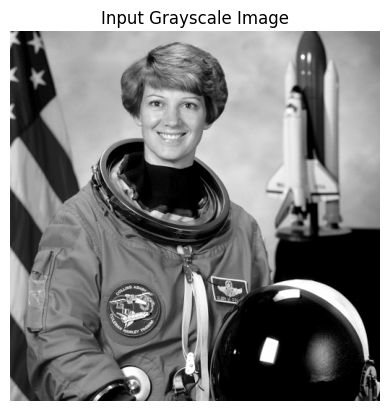

In [2]:
# 1) Load a self-contained grayscale image
img_rgb = data.astronaut()  # colorful & familiar
img_gray = color.rgb2gray(img_rgb)  # [0,1], float64
img = img_as_float32(img_gray)      # float32 for compactness

H, W = img.shape
OUT = "q3_outputs"
os.makedirs(OUT, exist_ok=True)

plt.figure(); plt.imshow(img, cmap="gray", vmin=0, vmax=1); plt.title("Input Grayscale Image"); plt.axis("off"); plt.show()
plt.imsave(f"{OUT}/input.png", img, cmap="gray", vmin=0, vmax=1)

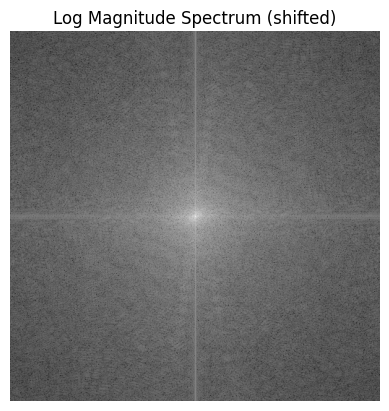

In [3]:
# 2) FFT and components
F = np.fft.fft2(img)
F_shift = np.fft.fftshift(F)  # for visualization (centered)

mag = np.abs(F_shift)
phase = np.angle(F_shift)

# Save log-magnitude spectrum for reference
eps = 1e-8
log_mag_vis = np.log(mag + eps)
log_mag_vis = (log_mag_vis - log_mag_vis.min()) / (log_mag_vis.max() - log_mag_vis.min() + eps)

plt.figure(); plt.imshow(log_mag_vis, cmap="gray"); plt.title("Log Magnitude Spectrum (shifted)"); plt.axis("off"); plt.show()
plt.imsave(f"{OUT}/log_magnitude_shifted.png", log_mag_vis, cmap="gray")

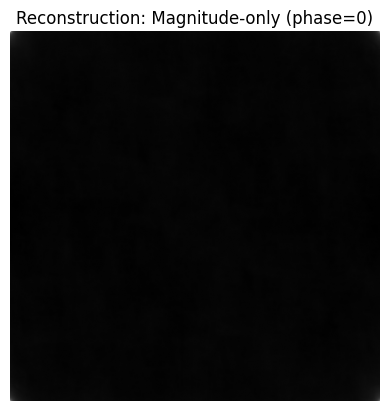

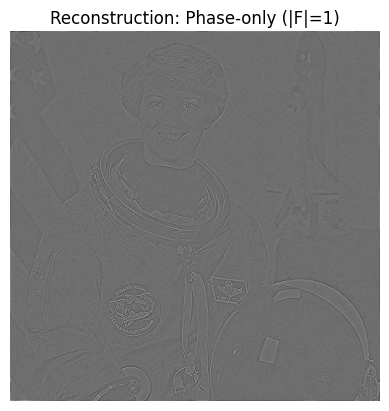

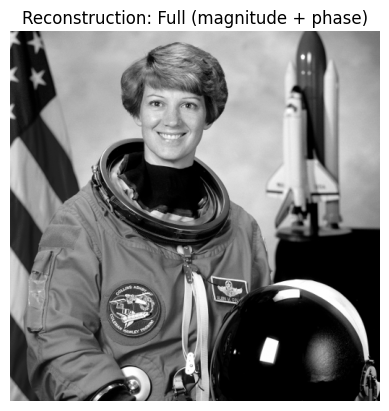

In [4]:
# 3) Reconstructions

def to_uint01(x):
    # normalize to [0,1] for display
    x = x - x.min()
    den = x.max() if x.max() > 1e-8 else 1.0
    return (x / den).astype(np.float32)

# (a) Magnitude-only: set phase = 0
F_magonly_shift = mag * np.exp(1j * 0.0)
F_magonly = np.fft.ifftshift(F_magonly_shift)
img_mag = np.fft.ifft2(F_magonly).real
img_mag = to_uint01(img_mag)

# (b) Phase-only: set magnitude = 1 (unit magnitude)
F_phaseonly_shift = np.exp(1j * phase)
F_phaseonly = np.fft.ifftshift(F_phaseonly_shift)
img_phase = np.fft.ifft2(F_phaseonly).real
img_phase = to_uint01(img_phase)

# (c) Full reconstruction: original magnitude + phase
F_full = np.fft.ifftshift(mag * np.exp(1j * phase))
img_full = np.fft.ifft2(F_full).real
img_full = to_uint01(img_full)

# Show and save
plt.figure(); plt.imshow(img_mag, cmap="gray", vmin=0, vmax=1); plt.title("Reconstruction: Magnitude-only (phase=0)"); plt.axis("off"); plt.show()
plt.imsave(f"{OUT}/recon_magnitude_only.png", img_mag, cmap="gray", vmin=0, vmax=1)

plt.figure(); plt.imshow(img_phase, cmap="gray", vmin=0, vmax=1); plt.title("Reconstruction: Phase-only (|F|=1)"); plt.axis("off"); plt.show()
plt.imsave(f"{OUT}/recon_phase_only.png", img_phase, cmap="gray", vmin=0, vmax=1)

plt.figure(); plt.imshow(img_full, cmap="gray", vmin=0, vmax=1); plt.title("Reconstruction: Full (magnitude + phase)"); plt.axis("off"); plt.show()
plt.imsave(f"{OUT}/recon_full.png", img_full, cmap="gray", vmin=0, vmax=1)

In [5]:
# 4) Tiny quantitative sanity check
# Full reconstruction should match input (up to normalization/rounding)
mse_full = float(np.mean((img_full - to_uint01(img))**2))

# Print basic stats for brief analysis
print("MSE (full recon vs normalized input):", mse_full)
print("Mean of magnitude-only recon:", float(img_mag.mean()))
print("Mean of phase-only recon:", float(img_phase.mean()))

MSE (full recon vs normalized input): 2.875876416890723e-14
Mean of magnitude-only recon: 0.0198059044778347
Mean of phase-only recon: 0.43295422196388245


## Brief Analysis (Why they differ)
- **Magnitude-only** discards all phase, so fine structure (edges, shapes) largely disappears; the result looks like a blurred, centrally symmetric pattern reflecting energy distribution.  
- **Phase-only** keeps phase and discards magnitude; despite lacking correct amplitudes, the **edges, contours, and object layout remain recognizable**, showing that phase carries most structural information.  
- **Full (magnitude+phase)** reconstructs the original (up to numeric normalization), confirming the Fourier pair consistency.

**Reference:** Oppenheim, A. V., Lim, J. S., & Curtis, S. R. (1983). Signal synthesis and reconstruction from partial Fourier-domain information. *JOSA*, 73(11), 1413–1420.

### How to Run
1. Open this notebook and **Run All code cell by cell**.  
2. Replace `data.astronaut()` with any grayscale image (or use `color.rgb2gray`) to try your own.